# Calculate subsidence in BKK at wellnests with 8 aquifers but simulates top four.

- Plotting two main figures for _Groundwater_ Paper
- Data availability graph: Figure 1 in paper
- GW well nest locations: Figure 6 in paper
- Forecast of GW and cumulative subsidence for BKK013: Figure 12 in paper

Author: Jenny Soonthornrangsan 2023, TU Delft

In [1]:
###############################################################################
# Installing packages on colab
###############################################################################
!pip install pastas
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1" 
!pip install "basemap-data-hires == 1.3.0b1"
!pip install mycolorpy
!git clone https://github.com/jsoontho/BKKSubPastasModels.git
    
# Changing current directory to location of python script
%cd '/content/BKKSubPastasModels'

!git pull

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'BKKSubPastasModels' already exists and is not an empty directory.


__Note that if imports don't work. Check results from cell above and click `Restart Runtime.` Then rerun cells below (including import cell)__

In [2]:
###############################################################################
# import statements
###############################################################################

# Importing packages and libraries
import os
import pandas as pd
import numpy as np
import pastas as ps
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import (AutoMinorLocator)
import string
import sys

# Changing current directory to locaiton of python script
%cd '/content/BKKSubPastasModels'

# Bangkok Subsidence Model Package
import bkk_sub_gw

# Importing script for pre-processing Thai GW data
import main_functions as mfs

/content/BKKSubPastasModels


In [3]:
###############################################################################
# Plotting settings
###############################################################################

plt.rc("font", size=10)  # controls default text size
plt.rc("axes", titlesize=10)  # fontsize of the title
plt.rc("axes", labelsize=6)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=6)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=6)  # fontsize of the y tick labels
plt.rc("legend", fontsize=5)  # fontsize of the legend
plt.rcParams['legend.title_fontsize'] = 6  # fontsize of legend title

In [ ]:
# Plotting pumping
# Reading in data
sheet = "EstTotalPump_54-60_Int50"
full_path = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
pump_50 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF25"
pump_25 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF100"
pump_100 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF50_25"
pump_50_25 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF0"
pump_0 = pd.read_excel(full_path, sheet_name=sheet)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(3.2, 6.4), dpi=300)
axs[0].plot(pump_50.Date, pump_50.Pump2, linewidth=1.5, label="500,000 m$^3$/day",
            color="hotpink")
axs[0].plot(pump_50.Date, pump_25.Pump2, linewidth=1.5, label="250,000 m$^3$/day",
            color="tab:orange")
axs[0].plot(pump_50.Date, pump_50_25.Pump2, linewidth=1.5,
            label="Delayed\n250,000 m$^3$/day",
            color="tab:green")
axs[0].plot(pump_50.Date, pump_100.Pump2, linewidth=1.5,
            label="1,000,000 m$^3$/day",
            color="tab:red")
axs[0].plot(pump_50.Date, pump_0.Pump2, linewidth=1.5, label="No Pumping",
            color="tab:purple")
axs[0].plot(pump_50.Date[:24472], pump_50.Pump2[:24472], linewidth=1.5, color="k",
            label="Historic Pumping")
axs[0].legend()
axs[0].grid(True, linestyle="dotted")
axs[0].set_xlim([datetime.date(1978, 1, 1), datetime.date(2059, 12, 31)])
plt.setp(axs[0].get_xticklabels(), visible=False)
axs[0].set_ylabel("Pumping Rate\n(m$^3$/day)")

# Plotting Groundwater forecasts
modelpath = os.path.abspath("models")
# Model files
modelfiles = os.listdir(modelpath)
Wellnest_name = "LCBKK013"
well_name = "PD32"
wellmodel = [s for s in modelfiles
             if np.logical_and(Wellnest_name in s, well_name in s)][0]
model = ps.io.load(modelpath + "/" + wellmodel)
pump_rfunc = ps.Gamma()
pumppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
EstTotPump = pd.read_excel(full_path, sheet_name=sheet)
pumpsheet = "EstTotalPump_54-60_Int50"

# Original pumping scenario 500,000 m3/day
# Loading model and simulating based on new scenario
time_min = "1978"
time_max = "2060"
head50 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 250,000 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF25"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head25 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 1,000,000 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF100"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head100 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 500,000 to 250,000 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF50_25"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head50_25 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 0 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF0"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head0 = model.simulate(tmin=time_min, tmax=time_max)

# Plotting
ax1 = plt.subplot(312, sharex=axs[0])
ax1.plot(head50, linewidth=1.5, label="500,000 m$^3$/day",
         color="hotpink")
ax1.plot(head25, linewidth=1.5, label="250,000 m$^3$/day",
         color="tab:orange")
ax1.plot(head50_25, linewidth=1.5, label="Delayed\n250,000 m$^3$/day",
         color="tab:green")
ax1.plot(head100, linewidth=1.5, label="1,000,000 m$^3$/day",
         color="tab:red")
ax1.plot(head0, linewidth=1.5, label="No Pumping",
         color="tab:purple")
ax1.plot(head0[:15654], linewidth=1.5, color="black",
         label="Observed Pumping")
ax1.grid(True, linestyle="dotted")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("Groundwater\nHead (m)")

# For each well nest
wellnestlist = ["LCBKK013"]
tmin = "1978"
tmax = "2060"

# Reading in thickness and storage data
path = os.path.join(os.path.abspath("inputs"), "SUBParameters.xlsx")
Thick_data = pd.read_excel(path, sheet_name="Thickness",
                           index_col=0)  # Thickness
Sskv_data = pd.read_excel(path,
                          sheet_name="Sskv",
                          index_col=0)  # Sskv
Sske_data = pd.read_excel(path,
                          sheet_name="Sske",
                          index_col=0)  # Ssk
K_data = pd.read_excel(path,
                       sheet_name="K",
                       index_col=0)  # K

# Mode can be "raw" as in raw groundwater data vs "Pastas" for importing Pastas
# simulated groundwater in the aquifers
mode = "Pastas"

# If mode is Pastas, need model path
if mode == "Pastas":

    mpath = os.path.abspath("models")

# Pumping flag, for PASTAS, if changing pumping scenario
pumpflag = 1
# If changing pumping scenario, need pumping sheet/path
if pumpflag == 1:

    ppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")

    # Pumping sheets
    pumpsheets = ["EstTotalPump_54-60_Int50",
                  "EstTotalPump_54-60_IntF25",
                  "EstTotalPump_54-60_IntF100",
                  "EstTotalPump_54-60_IntF50_25",
                  "EstTotalPump_54-60_IntF0"]

# Convergence criteria
CC = 1 * 10**-5

# Number of nodes in clay
node_num = 10

# Using available heads as proxy for missing
proxyflag = 1

# All ann subs
all_ann_subs = []

# For each pumping scenario
for pumpsheet in pumpsheets:

    # Calculates subsidence
    all_results, sub_total, subv_total = bkk_sub_gw.\
        bkk_sub.bkk_subsidence(wellnestlist,
                               mode, tmin,
                               tmax,
                               Thick_data,
                               K_data,
                               Sskv_data,
                               Sske_data,
                               CC=CC,
                               Nz=node_num,
                               ic_run=True,
                               proxyflag=proxyflag,
                               pumpflag=pumpflag,
                               pump_path=ppath,
                               pump_sheet=pumpsheet,
                               model_path=mpath)

    # Post process data
    sub_total, subv_total, ann_sub, \
        _ = bkk_sub_gw.bkk_sub.bkk_postproc(wellnestlist,
                                            sub_total,
                                            subv_total,
                                            all_results)

    all_ann_subs.append(ann_sub)

# Saving each scenario last annual rate
ann_2060_500 = []
ann_2060_250 = []
ann_2060_d250 = []
ann_2060_1000 = []
ann_2060_0 = []

ax2 = plt.subplot(313, sharex=axs[0])

# For each well nest
for num_well, wellnest in enumerate(wellnestlist):

    # -1000 is to convert to mm and negative because subsidence is positive
    # while uplift is negative
    # 500,000 m3/day scenario
    lastrate = (all_ann_subs[0][num_well][1].CumTotSum[-1] -
                all_ann_subs[0][num_well][1].CumTotSum[-2])*-1000  # mm
    ax2.plot(all_ann_subs[0][num_well][1].index,
             all_ann_subs[0][num_well][1].CumTotSum*-100,
             label="{:.1f}".format(lastrate), linewidth=1.5,
             color="hotpink")

    ann_2060_500.append(lastrate)

    # 250,000 m3/day scenario
    lastrate = (all_ann_subs[1][num_well][1].CumTotSum[-1] -
                all_ann_subs[1][num_well][1].CumTotSum[-2])*-1000   # mm
    ax2.plot(all_ann_subs[1][num_well][1].index,
             all_ann_subs[1][num_well][1].CumTotSum*-100,
             label="{:.1f}".format(lastrate), linewidth=1.5,
             color="tab:orange")
    ann_2060_250.append(lastrate)

    # 500,000 -> 250,000 m3/day scenario
    lastrate = (all_ann_subs[3][num_well][1].CumTotSum[-1] -
                all_ann_subs[3][num_well][1].CumTotSum[-2])*-1000  # mm
    ax2.plot(all_ann_subs[3][num_well][1].index,
             all_ann_subs[3][num_well][1].CumTotSum*-100,
             label="{:.1f}".format(lastrate), linewidth=1.5,
             color="tab:green")
    ann_2060_d250.append(lastrate)

    # 1,000,000 m3/day scenario
    lastrate = (all_ann_subs[2][num_well][1].CumTotSum[-1] -
                all_ann_subs[2][num_well][1].CumTotSum[-2])*-1000  # mm
    ax2.plot(all_ann_subs[2][num_well][1].index,
             all_ann_subs[2][num_well][1].CumTotSum*-100,
             label="{:.1f}".format(lastrate), linewidth=1.5,
             color="tab:red")
    ann_2060_1000.append(lastrate)

    # No pumping scenario
    lastrate = (all_ann_subs[4][num_well][1].CumTotSum[-1] -
                all_ann_subs[4][num_well][1].CumTotSum[-2])*-1000  # mm
    ax2.plot(all_ann_subs[4][num_well][1].index,
             all_ann_subs[4][num_well][1].CumTotSum*-100,
             label="{:.1f}".format(lastrate), linewidth=1.5,
             color="tab:purple")
    ann_2060_0.append(lastrate)

    # Observed pumping
    ax2.plot(all_ann_subs[4][num_well][1].index[:44],
             all_ann_subs[4][num_well][1].CumTotSum.iloc[:44]*-100,  # mm
             color="black", linewidth=1.5, label='_nolegend_')

    # Plotting settings
    plt.legend(title="2060 Rate\n  (mm/yr)",
               loc=4, fontsize=6, fancybox=True)
    ax2.set_ylabel("Cumulative\nSubsidence (cm)")
    ax2.set_xlabel("Years")
    ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
    plt.setp(ax2.get_xticklabels(), visible=True)
    ax2.grid(True, linestyle=(0, (1, 10)), which="minor")
    ax2.grid(True, linestyle="dotted", which="major")

    # Annotating specific points
    index_1990 = all_ann_subs[4][num_well][1].year == 1990
    index_2000 = all_ann_subs[4][num_well][1].year == 2000
    cum_value_1990 = all_ann_subs[4][num_well][1].CumTotSum[index_1990]*-100
    cum_value_2000 = all_ann_subs[4][num_well][1].CumTotSum[index_2000]*-100
    ann_value_1990 = all_ann_subs[4][num_well][1].AnnRates[index_1990]*-1000
    ann_value_2000 = all_ann_subs[4][num_well][1].AnnRates[index_2000]*-1000
    ax2.scatter(cum_value_1990.index, cum_value_1990[0], color="cyan")
    ax2.scatter(cum_value_2000.index, cum_value_2000[0], color="cyan")
    # annotation
    ax2.text(cum_value_1990.index, cum_value_1990[0] - 4, "1990: " +
             f"{ann_value_2000[0]:.1f}" + " mm/yr", fontsize=6)
    # annotation
    ax2.text(cum_value_2000.index, cum_value_2000[0] - 4, "2000: " +
             f"{ann_value_1990[0]:.1f}" + " mm/yr", fontsize=6)
    plt.tight_layout()
    plt.show()

axs[1] = ax1
axs[2] = ax2

# a), b), c) labels for paper
for index, ax in enumerate(axs):

    ax.text(-.2, 1.0, string.ascii_lowercase[index] + ")",
            transform=ax.transAxes,
            size=10, weight='bold')

# Saving
path = "figures"
fig_name = "ForecastFigs.png"
full_figpath = os.path.join(path, fig_name)
plt.savefig(full_figpath, dpi=300, bbox_inches="tight", format="png")

fig_name = "ForecastFigs.eps"
full_figpath = os.path.join(path, fig_name)
plt.savefig(full_figpath, dpi=300, bbox_inches="tight", format="eps")

/content/BKKSubPastasModels/main_functions.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.Year.loc[i] = (date_list[i].year) - 543
/content/BKKSubPastasModels/main_functions.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.Month.loc[i] = (date_list[i].month)
/content/BKKSubPastasModels/main_functions.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.Day.loc[i] = (date_list[i].day)
<ipython-input-4-f0

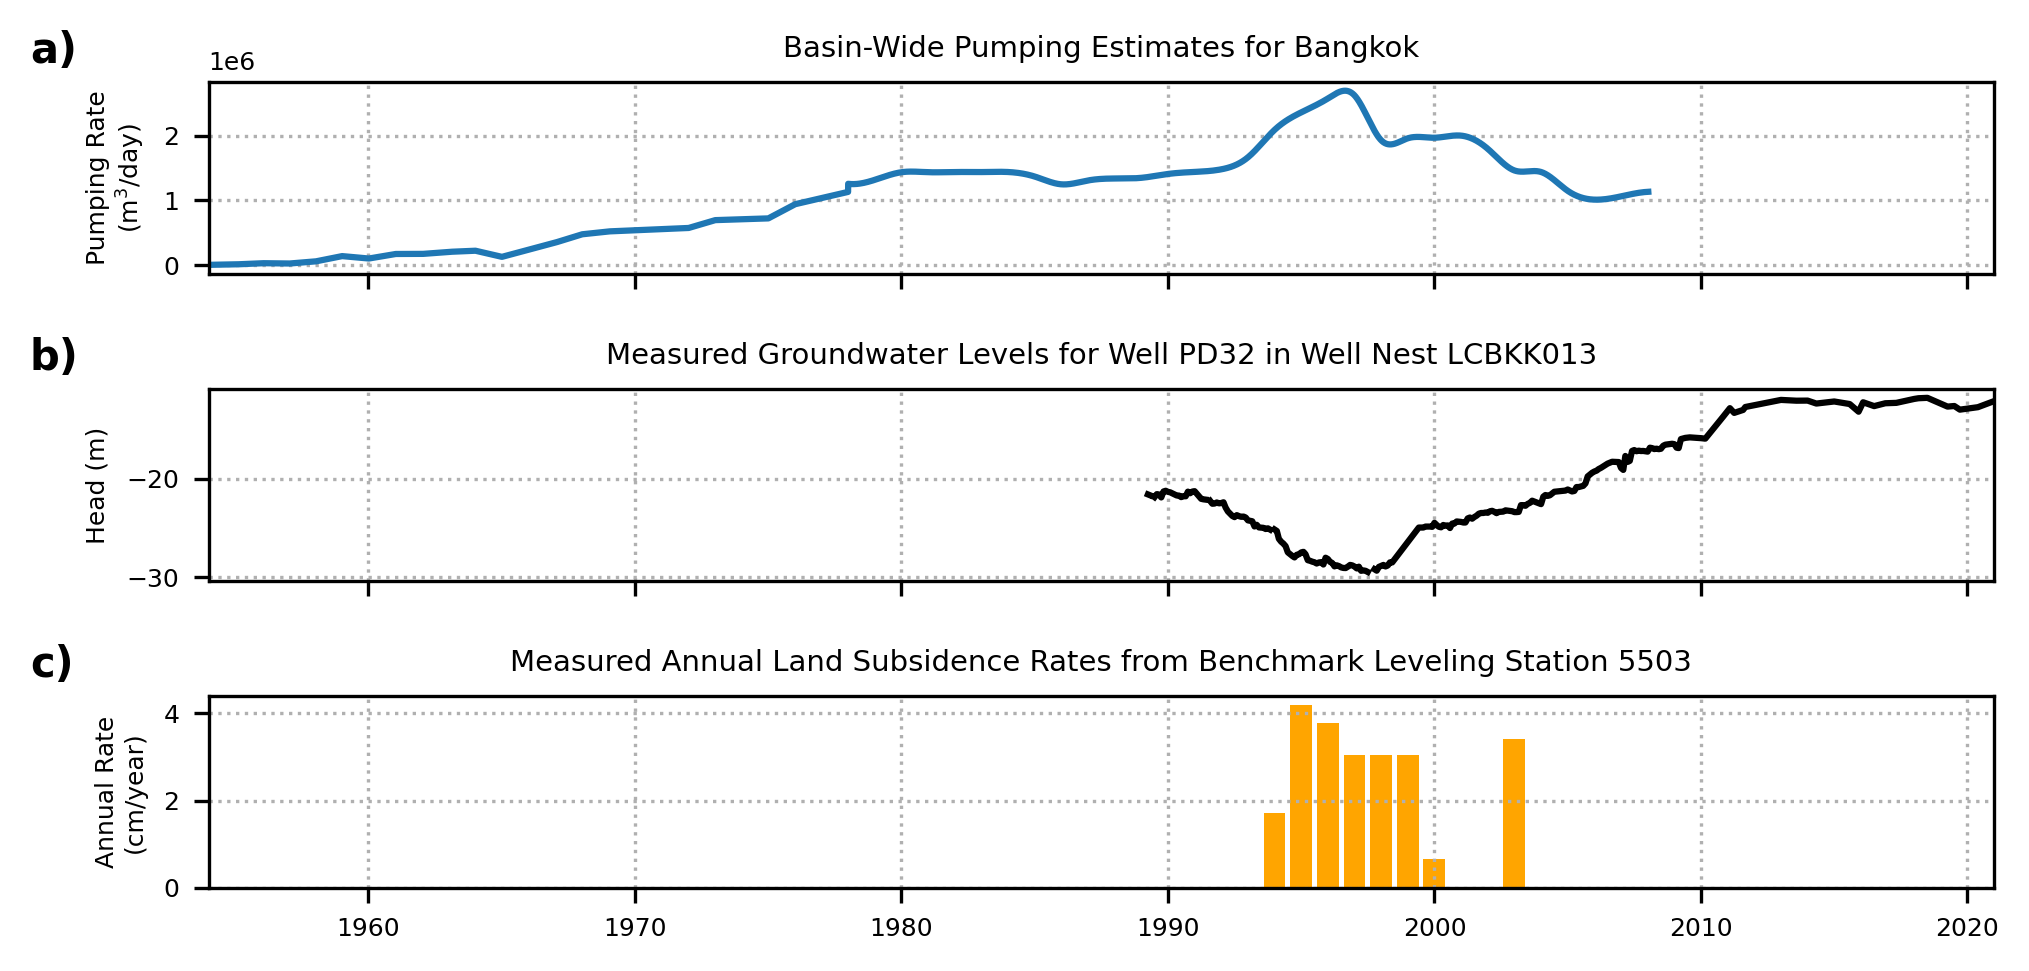

In [4]:
# %% Data availability
###############################################################################
# Plotting settings
###############################################################################

plt.rc("font", size=12)  # controls default text size
plt.rc("axes", titlesize=5)  # fontsize of the title
plt.rc("axes", labelsize=6)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=6)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=6)  # fontsize of the y tick labels
plt.rc("legend", fontsize=6)  # fontsize of the legend
# Pumping vs groundwater vs levelling measurements

# Plotting pumping
# Reading in data
sheet = "EstTotalPump_54-60_Int50"
pumppath = os.path.abspath("inputs/BasinPumping.xlsx")
pump_2020 = pd.read_excel(pumppath, sheet_name=sheet)

# Xticks
x = pd.date_range(start=pump_2020.Date[0],
                  end=pump_2020.Date[19733],
                  periods=8)

# Plotting
fig, axs = plt.subplots(3, sharex=True, figsize=(6.75, 3.38), dpi=300)
axs[0].plot(pump_2020.Date[:19733], pump_2020.Pump2[:19733], linewidth=1.5)
axs[0].set_ylabel("Pumping Rate\n(m$^3$/day)")
axs[0].set_title("Basin-Wide Pumping Estimates for Bangkok",
                 fontsize=7)
axs[0].grid(True, linestyle="dotted")

# Plottign groundwater
# Reading in groundwater data
Wellnest_name = "LCBKK013"
well_name = "PD32"
well_path = "inputs/"
full_path = os.path.join(well_path, Wellnest_name + ".xlsx")
data = pd.read_excel(full_path, skiprows=3)
all_head_data, gw_well_head = mfs.GW_Data_Process(data, well_name)

# CORRECTING GW HEAD DATA TO LAND SURFACE (COASTAL DEM 2.1)
landsurf_path = os.path.join(well_path,
                             "LandSurfElev_GWWellLocs.xlsx")

# Each well nest has its own Ss and K sheet
landsurf_data = pd.read_excel(landsurf_path,
                              sheet_name="2.1",
                              usecols="C:F",
                              index_col=0)

gw_well_head.Head += (landsurf_data.RASTERVALU.loc[Wellnest_name])
# Adding years and annual average heads
gw_well_head["year"] = gw_well_head.index.year
axs[1].plot(gw_well_head.index, gw_well_head.Head, color="k",
            linewidth=1.5)
axs[1].set_xlim(([datetime.date(1954, 1, 1), datetime.date(2020, 12, 31)]))
axs[1].set_ylabel("Head (m)")
axs[1].set_title("Measured Groundwater Levels for Well PD32 in Well Nest LCBKK013",
                 fontsize=7)
axs[1].grid(True, linestyle="dotted")
loc = os.path.join(os.path.abspath("inputs"), "SurveyingLevels.xlsx")

subdata = pd.read_excel(loc, sheet_name=Wellnest_name+"_Leveling",
                        index_col=3)
subdata = pd.DataFrame(subdata)
subdata.index = pd.to_datetime(subdata.index)

# Getting rid of benchmarks outside time period
subdata = subdata[(subdata.Year <= 2020)]

# Benchmarks should start at 0 at the first year.
bench = subdata.loc[:, subdata.columns.str.contains("Land")]
bench = bench.fillna(0)

if (bench.iloc[0] != 0).any():
    bench.iloc[0] = 0

# IMPORTANT INFO
# For benchmark measurements, the first year is 0, the second year is
# the compaction rate over that first year.
# For implicit Calc, the first year has a compaction rate over that
# year, so to shift benchmarks value to the previouse year to match
# Index has the right years
bench.index = bench.index.shift(-1, freq="D")
bench["date"] = bench.index

# Gets the last date of each year
lastdate = bench.groupby(pd.DatetimeIndex(bench["date"]).year,
                         as_index=False).agg({"date": max}).reset_index(drop=True)
bench = bench.loc[lastdate.date]

leveling = bench[
    bench.columns[
        bench.columns.str.contains("Land")].item()]

leveling[leveling == 0] = np.nan
axs[2].bar(leveling.index, -leveling.values, color="orange", width=300)
axs[2].xaxis_date()
axs[2].set_xlim(([datetime.date(1954, 1, 1), datetime.date(2020, 12, 31)]))
axs[2].set_ylabel("Annual Rate\n(cm/year)")
axs[2].set_title(
    "Measured Annual Land Subsidence Rates from Benchmark Leveling Station 5503",
    fontsize=7)
plt.tight_layout()
plt.rc("font", size=10)  # controls default text size
axs[2].grid(True, linestyle="dotted")

# a), b), c) labels for paper
for index, ax in enumerate(axs):

    ax.text(-.1, 1.1, string.ascii_lowercase[index] + ")",
            transform=ax.transAxes,
            size=10, weight='bold')

# Saving
path = "figures"
fig_name = "DataAvailability.eps"
full_figpath = os.path.join(path, fig_name)
plt.savefig(full_figpath, bbox_inches="tight", format="eps")

fig_name = "DataAvailability.png"
full_figpath = os.path.join(path, fig_name)
plt.savefig(full_figpath, bbox_inches="tight", format="png")

OSError: ignored

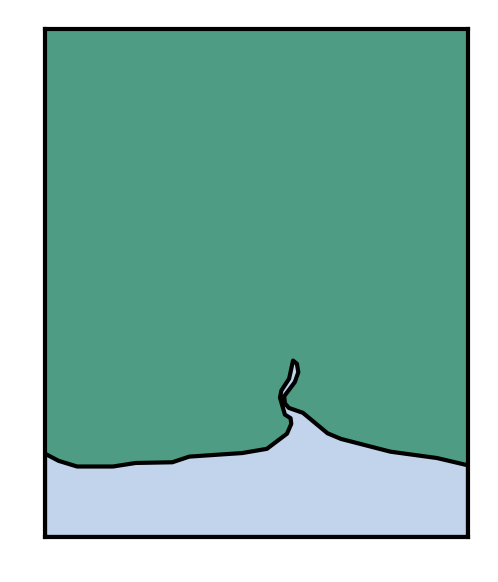

In [5]:
# %% Plotting groundwater well locations

path = os.path.abspath("figures")
bkk_sub_gw.bkk_plotting.gwlocs_map(path, save=1)